# Technical Assessment Report_Yuqi Chen

## Summary

Based on the GPS data of cow movements and the IMU (Inertial Measurement Unit) data of cows’ head facing, this report explores the assumption that cows face straight ahead while walking and evaluates its reasonableness. Findings are as follows:

- Cows do not face exactly straight ahead while walking but have a small deviation.
- As speed increases, the heading difference (the difference between head direction and movement direction) tends to decrease slightly, indicating that cows are more likely to face straight ahead at higher speeds.


## Introduction

The purpose of this report is to analyse the movement patterns of cows using GPS and IMU data collected from collars equipped with a GPS module and an IMU (Inertial Measurement Unit). The GPS provides the cow's location and movement direction, while the IMU provides the heading, indicating the direction the cow's head is facing. The primary goal is to investigate the assumption that cows face straight ahead while walking.

This report is structured as follows:

1. **Data Cleaning and Preparation**: The GPS and IMU data are loaded from CSV files. We begin by checking the data for completeness and duplication. We then convert the columns to suitable formats and merge the GPS and IMU data based on the Serial Number and NZDT columns. The headings are normalised to a common format (within 0 to 360 degrees).
2. **Data Visualisation and Analysis**: We explore the data through visualisations and statistical analysis. The visualisations include examining the distribution of heading differences, plotting the paths of the cows on a map, and visualizing the relationship between GPS speed and heading difference. And also conduct a multiple regression model to understand the relationship between the heading difference and other variables such as GPS speed.
3. **Conclusion and Comments**: The results from the data analysis are summarised, providing insights into the movement patterns of cows, identifying potential sources of error and suggesting improved ways of data collection. 

## Analysis and Discussion

### 1. Data Cleaning and Preparation
Data Overview：

- GPS Data: Contains timestamps, serial numbers, latitude, longitude, GPS heading, and GPS speed.
- IMU Data: Contains timestamps, serial numbers, and IMU heading values.


The code below performs the following steps:

- Loads the GPS and IMU data from CSV files.
- Checks the data any missing values and duplicate.
- Converts the timestamp columns to datetime format.
- Merges the GPS and IMU data on the Serial Number and NZDT columns.
- Convert headings to a common format (0 to 360 degrees).
- Calculates the difference between the IMU heading and the GPS heading.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm

In [104]:
# Load the GPS and IMU data
gps_data = pd.read_csv('gps_data.csv')
imu_data = pd.read_csv('imu_data.csv')

# Display GPS dataset
gps_data.head()

,Serial Number,NZDT,Latitude,Longitude,GPS Heading,GPS Speed
0,004-0009-00481,16/10/20 17:27:15,-37.553447,175.459181,11,0.938258
1,004-0009-00481,16/10/20 17:27:14,-37.553455,175.459178,3,1.627387
2,004-0009-00481,16/10/20 17:27:13,-37.553470,175.459177,359,1.680147
3,004-0009-00481,16/10/20 17:27:12,-37.553485,175.459177,6,0.614859
4,004-0009-00481,16/10/20 17:27:10,-37.553496,175.459176,3,1.594698


In [105]:
# Display IMU dataset
imu_data.head()

,Serial Number,NZDT,Heading
0,004-0009-00481,16/10/20 17:27:15,373.461806
1,004-0009-00481,16/10/20 17:27:14,364.935411
2,004-0009-00481,16/10/20 17:27:13,342.940320
3,004-0009-00481,16/10/20 17:27:12,351.169082
4,004-0009-00481,16/10/20 17:27:10,345.652691


In [106]:
# Check for missing data 
print("Missing values in GPS data:", gps_data.isnull().sum().sum())
print("Missing values in IMU data:", imu_data.isnull().sum().sum())

# Check for duplicate data
print("Duplicate records in GPS data:", gps_data.duplicated().sum())
print("Duplicate records in IMU data:", imu_data.duplicated().sum())

Missing values in GPS data: 0
Missing values in IMU data: 0
Duplicate records in GPS data: 0
Duplicate records in IMU data: 0


In [107]:
# Display Data Types
imu_data.dtypes

Serial Number     object
NZDT              object
Heading          float64
dtype: object

In [108]:
gps_data.dtypes

Serial Number     object
NZDT              object
Latitude         float64
Longitude        float64
GPS Heading        int64
GPS Speed        float64
dtype: object

The variable NZDT has a type of `object`, and we need to convert it to `datetime` format.

In [109]:
# Convert the NZDT columns to datetime
gps_data['NZDT'] = pd.to_datetime(gps_data['NZDT'], format='%d/%m/%y %H:%M:%S')
imu_data['NZDT'] = pd.to_datetime(imu_data['NZDT'], format='%d/%m/%y %H:%M:%S')

In [110]:
# Merge the datasets on Serial Number and NZDT
merged_data = pd.merge(gps_data, imu_data, on=['Serial Number', 'NZDT'])

# Display
merged_data.head()

,Serial Number,NZDT,Latitude,Longitude,GPS Heading,GPS Speed,Heading
0,004-0009-00481,2020-10-16 17:27:15,-37.553447,175.459181,11,0.938258,373.461806
1,004-0009-00481,2020-10-16 17:27:14,-37.553455,175.459178,3,1.627387,364.935411
2,004-0009-00481,2020-10-16 17:27:13,-37.553470,175.459177,359,1.680147,342.940320
3,004-0009-00481,2020-10-16 17:27:12,-37.553485,175.459177,6,0.614859,351.169082
4,004-0009-00481,2020-10-16 17:27:10,-37.553496,175.459176,3,1.594698,345.652691


In [112]:
# Summary statistics for headings
merged_data['Heading'].describe()

count    3309.000000
mean      277.904358
std       136.047919
min        20.025774
25%       317.944887
50%       345.186182
75%       360.689176
max       379.935999
Name: Heading, dtype: float64

In [113]:
merged_data['GPS Heading'].describe()

count    3309.000000
mean      141.389544
std       170.596580
min         0.000000
25%         2.000000
50%         7.000000
75%       355.000000
max       359.000000
Name: GPS Heading, dtype: float64

The maximum heading value is over 360 degrees, so we normalise the data within the 0-360 degree range. This ensures that all heading values are represented correctly within a full circle. 

In [64]:
# Ensure headings are within the 0-360 degree range
merged_data['Heading'] = merged_data['Heading'] % 360

In [76]:
# Calculate the difference between IMU Heading and GPS Heading
merged_data['Heading Difference'] = merged_data.apply(
    lambda x: min(abs(x['Heading'] - x['GPS Heading']), 
                    360 - abs(x['Heading'] - x['GPS Heading'])), axis=1
)

In [77]:
# Display the first few rows of the processed merged dataset
merged_data.head()

,Serial Number,NZDT,Latitude,Longitude,GPS Heading,GPS Speed,Heading,Heading Difference
0,004-0009-00481,2020-10-16 17:27:15,-37.553447,175.459181,11,0.938258,13.461806,2.461806
1,004-0009-00481,2020-10-16 17:27:14,-37.553455,175.459178,3,1.627387,4.935411,1.935411
2,004-0009-00481,2020-10-16 17:27:13,-37.553470,175.459177,359,1.680147,342.940320,16.059680
3,004-0009-00481,2020-10-16 17:27:12,-37.553485,175.459177,6,0.614859,351.169082,14.830918
4,004-0009-00481,2020-10-16 17:27:10,-37.553496,175.459176,3,1.594698,345.652691,17.347309


### 2. Visualisation and Analysis

#### 2.1 Distribution of Heading Differences

The chart below plotted the distribution of heading differences, which illustrates that most heading differences are within a range of 0 to 40 degrees. The mean and median(50%) heading differences are around 17 degrees, indicating that cows do not face exactly straight ahead while walking but have a small deviation.

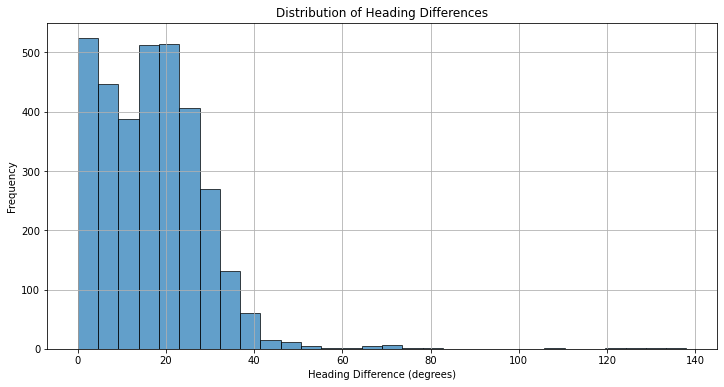

count    3309.000000
mean       16.991542
std        12.030533
min         0.006267
25%         7.721167
50%        16.486700
75%        24.024919
max       138.019127
Name: Heading Difference, dtype: float64

In [99]:
# Plot the distribution of heading differences
plt.figure(figsize=(12, 6))
plt.hist(merged_data['Heading Difference'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Heading Differences')
plt.xlabel('Heading Difference (degrees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Summary statistics for heading differences
merged_data['Heading Difference'].describe()


#### 2.2 Cow Paths with Speed and Heading Difference

The visualisation below displays the movement paths of multiple cows, each represented by a separate subplot. Below is the graph description:
- X-axis (Longitude): Represents the longitudinal coordinate of the cow's position.
- Y-axis (Latitude): Represents the latitudinal coordinate of the cow's position.
- points: Each point represents a recorded position of the cow over time.
- Colour: The colour of the points represents the GPS speed(m/s) of the cow. A colour bar is displayed on the right side of the entire figure. The slower the speed, the darker the colour.
- Size: The size of the points represents the heading difference of the cow. Larger points indicate a greater difference.


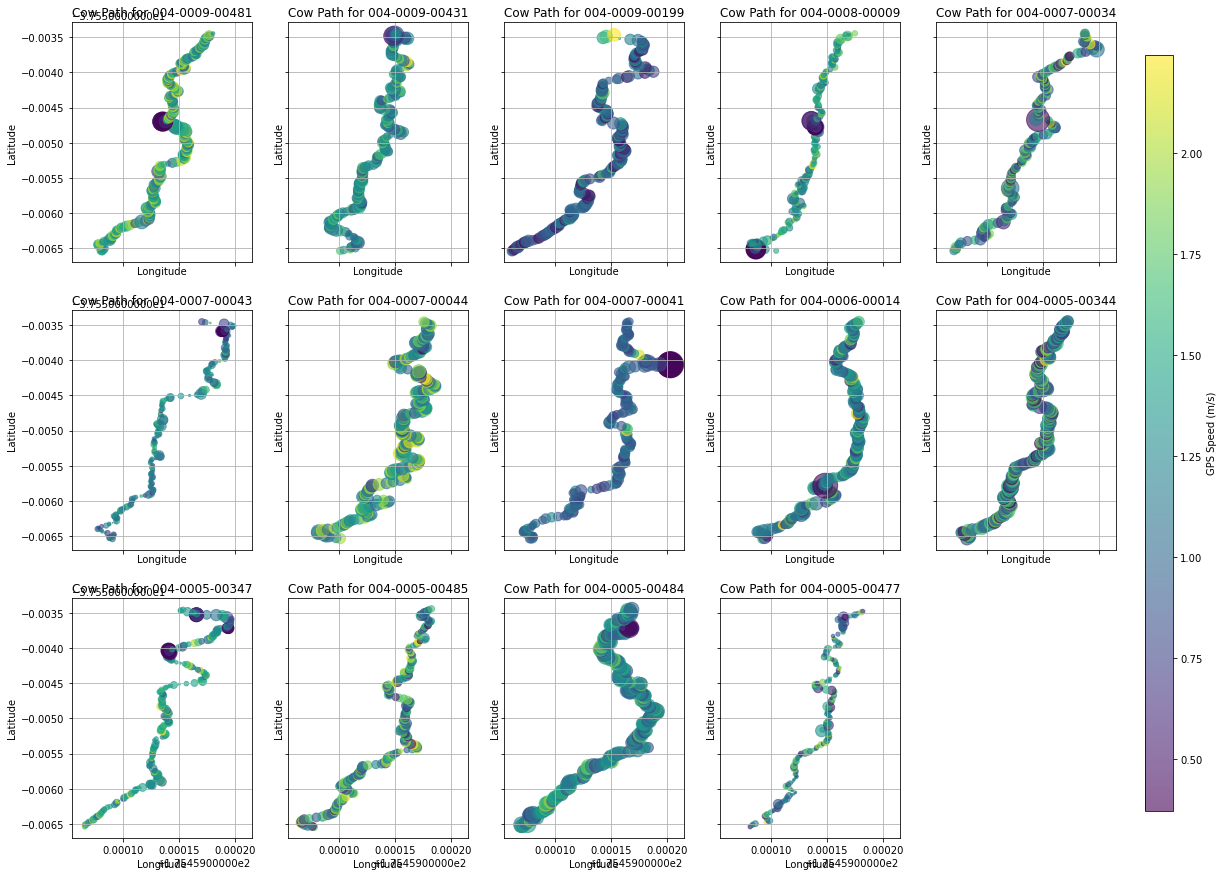

In [95]:
# Extract unique cow serial numbers
cows = merged_data['Serial Number'].unique()

# Define the number of columns for the layout
ncols = 5
nrows = 3

# Create a plot for each cow's path with speed and heading, sorted by time
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5*nrows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the array of axes for easier iteration

for ax, cow in zip(axes, cows):
    cow_data = merged_data[merged_data['Serial Number'] == cow].sort_values(by='NZDT')
    sc = ax.scatter(cow_data['Longitude'], cow_data['Latitude'], c=cow_data['GPS Speed'], cmap='viridis', 
                    s=cow_data['Heading Difference']*5, label=cow, alpha=0.6)
    ax.set_title(f'Cow Path for {cow}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)

# Remove any unused axes
for ax in axes[len(cows):]:
    fig.delaxes(ax)

# Add a shared color bar for speed
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7]) #lower-left x,y,width,height
fig.colorbar(sc, cax=cbar_ax).set_label('GPS Speed (m/s)')

plt.show()

The general direction of the cows is consistent; however, when the speed is slow, it is more likely to observe a larger heading difference. This trend is clearly demonstrated by the No.41 cow, where the graph shows that darker-coloured dots, representing slower speeds, are larger. This pattern suggests that cows may be more exploratory or distracted when moving slowly, resulting in larger heading differences. Conversely, as speed increases, cows tend to face more directly in the direction of their movement, reducing the heading difference.

#### 2.3 Regression Model 

We will use a linear regression model to examine how GPS Speed and location influence the heading difference.

In [67]:
# Prepare the data for regression analysis
X = merged_data[['GPS Speed', 'Latitude', 'Longitude']]
y = merged_data['Heading Difference']

# Add a constant term to the predictors to include the intercept in the model
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the model summary
model_summary = model.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Heading Difference   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     63.14
Date:                Fri, 26 Jul 2024   Prob (F-statistic):           1.09e-39
Time:                        14:28:13   Log-Likelihood:                -12834.
No. Observations:                3309   AIC:                         2.568e+04
Df Residuals:                    3305   BIC:                         2.570e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.948e+07   2.16e+06     -9.040      0.000   -2.37e+07   -1.53e+07
GPS Speed     -4.8761      0.470    -10.380      0.000      -5.797      -3.955
Latitude   -2655.3437    376.784     -7.047      0.000   -3394.098   -1916.590
Longitude   1.105e+05   1.22e+04      9.042      0.000    8.65e+04    1.34e+05
==============================================================================
Omnibus:                     1501.605   Durbin-Watson:                   0.443
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19396.257
Skew:                           1.810   Prob(JB):                         0.00
Kurtosis:                      14.295   Cond. No.                     1.90e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.95e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**The F-statistic for the regression model is 63.14 (p < 0.001), indicating that the model is statistically significant. This means that the predictors used in the model are significant and contribute to explaining the variation in heading differences.**

**The coefficient for GPS speed is -4.8761, indicating a negative relationship between speed and heading difference. This suggests that as speed increases, the heading difference tends to decrease slightly, which aligns with our earlier visualisation analysis. This finding implies that cows tend to face more directly in the direction of their movement at higher speeds, reducing deviations between their head direction and their movement direction.**

## Conclusion and Comments

1. **Movement Patterns**: Cows generally exhibit small deviations from facing straight ahead while walking. The heading difference tends to decrease slightly as speed increases, indicating that cows are more likely to face directly in the direction of their movement at higher speeds.

2. **Anomalies**: The analysis identified anomalies in heading values greater than 360 degrees. These were normalised to within the 0-360 degree range to ensure accurate representation and analysis.

3. **Potential Sources of Error**: Potential sources of error include GPS and IMU inaccuracies, calibration issues, and environmental factors affecting sensor readings. These errors can impact the precision of the heading and speed data.

4. **Improvements in Data Collection**: Regularly calibrate sensors to ensure accurate readings. Collect data at a higher frequency to capture more detailed movement patterns. Minimise environmental factors that may affect sensor accuracy, such as obstructions or interference.

